In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_set, val_set = dataset['train'], dataset['validation']

In [4]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_set), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_set), target_vocab_size=2**13)

In [5]:
instance = 'This is a translation machine from Portuguese to English.'

tokenized_string = tokenizer_en.encode(instance)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == instance

Tokenized string is [7915, 128, 13, 7, 6512, 7863, 1057, 48, 7911, 1785, 3662, 6939, 104, 5, 7900, 321, 4230, 7935, 7877]
The original string: This is a translation machine from Portuguese to English.


In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [7]:
def start_end(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [8]:
def tf_start_end(pt, en):
  result_pt, result_en = tf.py_function(start_end, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [9]:
MAX_LENGTH = 30
def maximum_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [10]:
#filter train set
train_ds = y=train_set.map(tf_start_end)
train_ds = train_ds.filter(maximum_length)

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

#filter val set
val_ds = val_set.map(tf_start_end)
val_ds = val_ds.filter(maximum_length).padded_batch(BATCH_SIZE)

In [11]:
pt_batch, en_batch = next(iter(val_ds))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 30), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,   67,  107, ...,    0,    0,    0],
        [8214,    8, 6503, ...,    0,    0,    0],
        [8214, 3050,    3, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 29), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   94,  136, ...,    0,    0,    0],
        [8087,   65,   13, ...,    0,    0,    0],
        [8087,   65, 4358, ...,    0,    0,    0]])>)

In [12]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [13]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [15]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [16]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [17]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [18]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

In [19]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [20]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [21]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [22]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [23]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [24]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [26]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [27]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [28]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [30]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [32]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [33]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [34]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [35]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [36]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [37]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [38]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [39]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

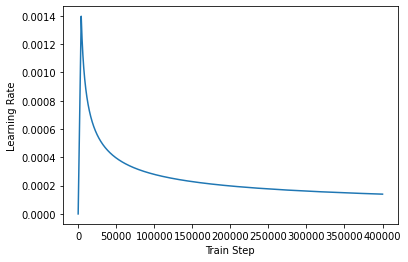

In [42]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(400000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [44]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [45]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [46]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [47]:
def create_masks(inp, tar):
  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [48]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [99]:
EPOCHS = 60

In [100]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [101]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_ds):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3353 Accuracy 0.4714
Epoch 1 Batch 50 Loss 0.3522 Accuracy 0.4877
Epoch 1 Batch 100 Loss 0.3615 Accuracy 0.4847
Epoch 1 Batch 150 Loss 0.3683 Accuracy 0.4804
Epoch 1 Batch 200 Loss 0.3738 Accuracy 0.4798
Epoch 1 Batch 250 Loss 0.3793 Accuracy 0.4791
Epoch 1 Batch 300 Loss 0.3843 Accuracy 0.4772
Epoch 1 Batch 350 Loss 0.3897 Accuracy 0.4760
Epoch 1 Batch 400 Loss 0.3944 Accuracy 0.4757
Epoch 1 Batch 450 Loss 0.3996 Accuracy 0.4750
Epoch 1 Batch 500 Loss 0.4050 Accuracy 0.4741
Epoch 1 Batch 550 Loss 0.4099 Accuracy 0.4740
Epoch 1 Batch 600 Loss 0.4147 Accuracy 0.4738
Epoch 1 Loss 0.4152 Accuracy 0.4739
Time taken for 1 epoch: 41.0070059299469 secs

Epoch 2 Batch 0 Loss 0.3936 Accuracy 0.4983
Epoch 2 Batch 50 Loss 0.3491 Accuracy 0.4775
Epoch 2 Batch 100 Loss 0.3581 Accuracy 0.4758
Epoch 2 Batch 150 Loss 0.3635 Accuracy 0.4792
Epoch 2 Batch 200 Loss 0.3704 Accuracy 0.4774
Epoch 2 Batch 250 Loss 0.3757 Accuracy 0.4772
Epoch 2 Batch 300 Loss 0.3794 Accuracy 0.4778
Epo

In [103]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    predictions = predictions[: ,-1:, :]  

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [104]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [107]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to very quickly share with you a few magic stories that had happened .


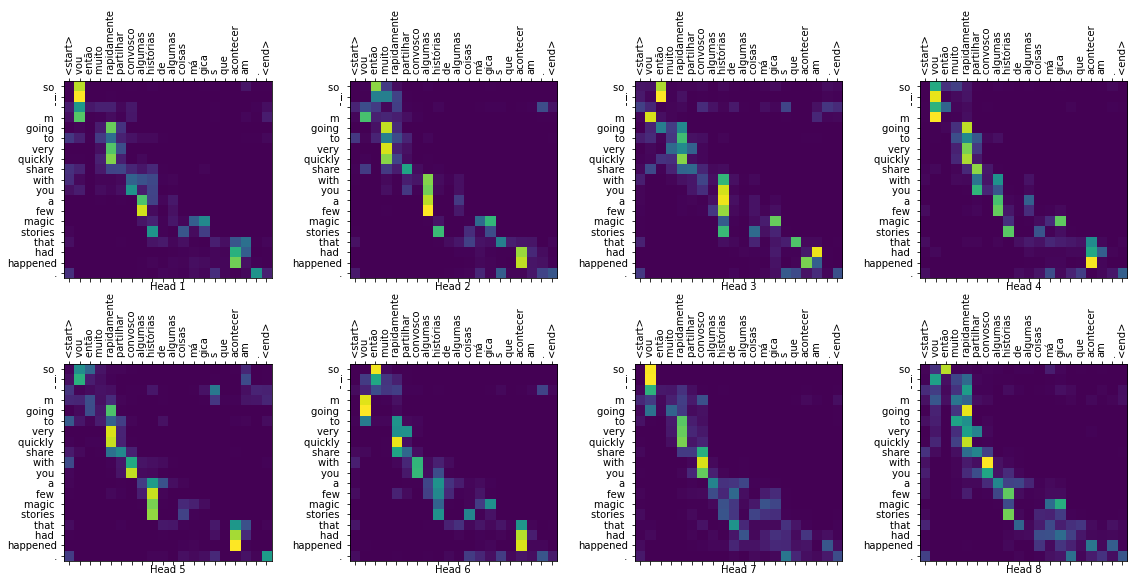

Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


In [110]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.", plot='decoder_layer4_block2')
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

In [69]:
sample_dataset = tf.data.Dataset.sample_from_datasets([val_set])

In [102]:
from random import sample
list(sample_dataset.as_numpy_iterator())

[(b'tinham comido peixe com batatas fritas ?',
  b'did they eat fish and chips ?'),
 (b'estava sempre preocupado em ser apanhado e enviado de volta .',
  b'i was always worried about being caught and sent back .'),
 (b'escolhi um com o tom de pele de uma lagosta com um escald\xc3\xa3o .',
  b'i chose one with the skin color of a lobster when sunburnt .'),
 (b'mas eu penso que isto \xc3\xa9 claramente falso .',
  b'but i think this is quite clearly untrue .'),
 (b'temos medido o nosso progresso muito rigorosamente .',
  b'we have measured our progress very rigorously .'),
 (b'e , na minha opini\xc3\xa3o , \xc3\xa9 uma cura n\xc3\xa3o s\xc3\xb3 para mim , mas para toda a gente .',
  b"and from what i feel , it 's a cure for me , but for us all ."),
 (b'\xc3\xa9 um trabalho em desenvolvimento de uma hist\xc3\xb3ria pessoal para uma hist\xc3\xb3ria global .',
  b"it 's a work in progress from a personal story to a global history ."),
 (b'quero dizer , \xc3\xa9 uma proposta perdedora .',
  

In [163]:
translate('mas claro, corda não tem nada a ver com eles.')
print('Correct translation is : but of course , rope has nothing to do with them  .')

Input: mas claro, corda não tem nada a ver com eles.
Predicted translation: but of course , it 's nothing to do with them .
Correct translation is : but of course , rope has nothing to do with them  .


In [165]:
translate('as pessoas têm aptidões muito diferentes.')
print('Correct translation is : people have very different aptitudes .')

Input: as pessoas têm aptidões muito diferentes.
Predicted translation: people have very different susceptibilities .
Correct translation is : people have very different aptitudes .


In [166]:
translate('eles pensam nele como um líder.')
print('Correct translation is : they think of him as a leader .')

Input: eles pensam nele como um líder.
Predicted translation: they think of them as a leader .
Correct translation is : they think of him as a leader .


In [167]:
translate('eles são exatamente o que parecem .')
print("Correct translation is : they're exactly what they sound like .")

Input: eles são exatamente o que parecem .
Predicted translation: they exactly what they seem .
Correct translation is : they're exactly what they sound like .


In [164]:
translate('outra vez .')
print('Correct translation is : and again .')

Input: outra vez .
Predicted translation: again , this one again .
Correct translation is : and again .


In [148]:
translate('na verdade , nos anos em que eu recolhi dados , apenas uma experi\xc3\xaancia chegou perto de ser perfeita .')
print('Correct translation is : in fact , in the years that i gathered data , only one experience came close to being the perfect one .')

Input: na verdade , nos anos em que eu recolhi dados , apenas uma experiÃªncia chegou perto de ser perfeita .
Predicted translation: in fact , in the years i sampled data , just a prevented some of prevention of completely perfect it .
Correct translation is : in fact , in the years that i gathered data , only one experience came close to being the perfect one .


In [150]:
translate('e eu era o único nos Estados Unidos escrevendo sobre derramamentos de óleo.')
print('Correct translation is : and i was the only one in the united states writing on oil spills .')

Input: e eu era o único nos Estados Unidos escrevendo sobre derramamentos de óleo.
Predicted translation: and i was the only way to get involved that it was using his names called rathe 's oil .
Correct translation is : and i was the only one in the united states writing on oil spills .


In [151]:
translate('tinham comido peixe com batatas fritas ?')
print('Correct translation is : did they eat fish and chips ?')

Input: tinham comido peixe com batatas fritas ?
Predicted translation: did you hear fish with their lives fried ?
Correct translation is : did they eat fish and chips ?


In [152]:
translate('mas aqui , elas simplesmente saem e voltam .')
print('Correct translation is : but here , just they leave and come back .')

Input: mas aqui , elas simplesmente saem e voltam .
Predicted translation: but just these things just come back and back .
Correct translation is : but here , just they leave and come back .


In [153]:
translate('para alguns de nós pode ser música. para alguns de nós pode ser comida .')
print('Correct translation is : for some of us it might be music . for some of us it might be food .')

Input: para alguns de nós pode ser música. para alguns de nós pode ser comida .
Predicted translation: for some of us can be music. for some of us can be food .
Correct translation is : for some of us it might be music . for some of us it might be food .


In [154]:
translate('aqui está o caso de negócios para a sustentabilidade.')
print('Correct translation is : here is the business case for sustainability .')

Input: aqui está o caso de negócios para a sustentabilidade.
Predicted translation: here 's the business case for sustainability .reverse .
Correct translation is : here is the business case for sustainability .


In [138]:
translate('stabelecemos 2020 como o ano da nossa meta para zero , para chegar ao topo do cume do monte sustentabilidade .')
print("Correct translation is : we 've set 2020 as our target year for zero , for reaching the top , the summit of mount sustainability .")

Input: stabelecemos 2020 como o ano da nossa meta para zero , para chegar ao topo do cume do monte sustentabilidade .
Predicted translation: we stereotyped 20 about our own half-version , just to almost at the top of sustainability are sustained .
correct translation is : we 've set 2020 as our target year for zero , for reaching the top , the summit of mount sustainability .


In [155]:
translate('eles estão em constante atualização e, em alguns casos, o governo ajuda.')
print('Correct translation is : they are constantly upgrading , and in a few cases , the government helps .')

Input: eles estão em constante atualização e, em alguns casos, o governo ajuda.
Predicted translation: they 're in constant current case , and in some cases , what is scientists at all help bring humans from .
Correct translation is : they are constantly upgrading , and in a few cases , the government helps .


In [156]:
translate('eu fui para a china no dia 15 de fevereiro de 2006 .')
print('Correct translation is : i made it to china on february 15 , 2006 .')

Input: eu fui para a china no dia 15 de fevereiro de 2006 .
Predicted translation: i went to china on the 15 day of 2004 .
Correct translation is : i made it to china on february 15 , 2006 .


In [157]:
translate("este é um problema que temos que resolver.")
print ("Correct translation is : Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: so this is a problem that we must solve our problem in a problem is that we must solve it .
Correct translation is : Real translation: this is a problem we have to solve .


In [158]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Correct translation is : Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors had gotten about this idea .
Correct translation is : Real translation: and my neighboring homes heard about this idea .


In [159]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Correct translation is : Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to very quickly share with you a few magic stories that had happened .
Correct translation is : Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


In [160]:
translate("mas aqui , elas simplesmente saem e voltam .")
print ("Correct translation is : but here , just they leave and come back .")

Input: mas aqui , elas simplesmente saem e voltam .
Predicted translation: but just these things just come back and back .
Correct translation is : but here , just they leave and come back .


In [161]:
translate("com essas pessoas eu ainda saio .")
print("Correct translation is : these people i still do hang out with .")

Input: com essas pessoas eu ainda saio .
Predicted translation: these people still pass it out .
Correct translation is : these people i still do hang out with .


In [162]:
translate("este é o primeiro livro que eu fiz.")
print ("Correct translation is : Real translation: this is the first book i've ever done.")

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .
Correct translation is : Real translation: this is the first book i've ever done.
